# Green Trap Analysis

Use this notebook to explore clustering and machine learning analyses on the processed WDI features.

In [ ]:
# --- CELL 1: Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Statistics
from scipy import stats

# Panel Regression
try:
    from linearmodels import PanelOLS
except ImportError:
    print("⚠️ 'linearmodels' library not found. Installing...")
    !pip install linearmodels
    from linearmodels import PanelOLS

# Add 'src' to path
sys.path.append(os.path.abspath('../src'))
import config

# Plotting Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print("✅ Libraries loaded. Ready for 5-Step Analysis Workflow!")

In [ ]:
# --- CELL 2: Load Data ---
try:
    df = pd.read_csv(config.PROCESSED_DATA_PATH)
    print(f"✅ Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

    # Set Panel Index for later steps
    df_panel = df.set_index(['Country_Code', 'Year'])
    print("✅ Panel index set successfully.")

except FileNotFoundError:
    print(f"❌ Error: File not found at {config.PROCESSED_DATA_PATH}")
    print("   Please run 'python -m src.preprocessor' first.")

In [ ]:
# --- CELL 3: Step 1 - Descriptive Analysis ---
print("\n📊 STEP 1: DESCRIPTIVE ANALYSIS")

# 1. Turkey Time Series (Inflation vs. Renewables vs. Imports)
tur = df[df['Country_Code'] == 'TUR'].sort_values('Year')

fig, ax1 = plt.subplots(figsize=(14, 6))

# Area plot for Crisis Periods
# (Assuming 'Period' column exists from preprocessor)
crisis_years = tur[tur['Period'].isin(['Financial_Crisis', 'Pandemic', 'Energy_Crisis'])]['Year']
for year in crisis_years:
    ax1.axvspan(year-0.5, year+0.5, color='gray', alpha=0.15)

# Left Axis: Inflation
color1 = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Inflation (CPI %)', color=color1)
ax1.plot(tur['Year'], tur['Inflation_CPI_Pct'], color=color1, linewidth=3, label='Inflation')
ax1.tick_params(axis='y', labelcolor=color1)

# Right Axis: Green & Energy
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Renewable Share (%) / Energy Imports (%)', color=color2)
ax2.plot(tur['Year'], tur['Renewable_Energy_Consumption_Pct'], color=color2, linestyle='--', linewidth=2, label='Renewable Share')
ax2.plot(tur['Year'], tur['Energy_Imports_Net_Pct'], color='tab:blue', linestyle=':', linewidth=2, label='Energy Import Dep.')
ax2.tick_params(axis='y', labelcolor=color2)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("🇹🇷 Turkey: Inflation, Green Transition, and Energy Dependence (with Crisis Periods)")
plt.show()

# 2. Peer Comparison (Turkey vs. Green Leaders & Peers)
print("\n🌍 COMPARISON: Turkey vs. Peers")
peers = config.TURKEY_PEERS_EMERGING
leaders = ['DEU']
comparison_countries = ['TUR'] + peers + leaders

comp_df = df[df['Country_Code'].isin(comparison_countries)].copy()

plt.figure(figsize=(14, 6))
sns.lineplot(data=comp_df, x='Year', y='Inflation_CPI_Pct', hue='Country_Code',
             style='Country_Group', palette='tab10', linewidth=2)
plt.title("Inflation Trajectories: Turkey vs. Peers & Green Leaders")
plt.ylabel("Inflation (%)")
plt.show()

In [ ]:
# --- CELL 4: Step 2 - Clustering & PCA ---
print("\n🧩 STEP 2: CLUSTERING & PCA")

# 1. Feature Selection for Clustering
# We want to group countries by their "Green-Macro" profile
cluster_feats = [
    'Renewable_Energy_Consumption_Pct',
    'Inflation_CPI_Pct',
    'GDP_Growth_Pct',
    'Energy_Imports_Net_Pct',
    'Trade_Pct_GDP',
    'Energy_Intensity_Primary_MJ_Per_GDP'
]

# Prepare Data (Mean over last 5 years to get recent structural "types")
recent_df = df[df['Year'] >= 2018].groupby('Country_Code')[cluster_feats].mean().dropna()

# Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(recent_df)

# 2. Optimal K (Silhouette Score)
print("   Calculating Optimal K...")
scores = []
k_range = range(2, 8)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    scores.append(silhouette_score(X_scaled, km.fit_predict(X_scaled)))

best_k = k_range[np.argmax(scores)]
print(f"   ✅ Optimal Number of Clusters (k): {best_k}")

# 3. Run K-Means
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
recent_df['Cluster'] = kmeans.fit_predict(X_scaled)

# 4. PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
recent_df['PC1'] = X_pca[:, 0]
recent_df['PC2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=recent_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=200, style='Cluster')

# Annotate Countries
for country in recent_df.index:
    # Label Turkey, Peers, and Leaders
    if country == 'TUR' or country in config.TURKEY_PEERS_EMERGING or country in config.GREEN_LEADERS:
        x_pos = recent_df.loc[country, 'PC1']
        y_pos = recent_df.loc[country, 'PC2']
        weight = 'bold' if country == 'TUR' else 'normal'
        color = 'red' if country == 'TUR' else 'black'
        plt.text(x_pos+0.1, y_pos+0.1, country, color=color, weight=weight, fontsize=11)

plt.title(f"Country Clusters (PCA): Where does Turkey Fall? (k={best_k})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")
plt.show()

# Show Turkey's Cluster Stats
tur_cluster = recent_df.loc['TUR', 'Cluster']
print(f"\n🇹🇷 Turkey is in Cluster {tur_cluster}")
print("Cluster Averages:")
print(recent_df.groupby('Cluster')[cluster_feats].mean().round(2))

In [ ]:
# --- CELL 5: Step 3 - Random Forest ---
print("\n🌲 STEP 3: RANDOM FOREST (Feature Importance)")

# 1. Define Features (12+ features as requested)
rf_features = [
    'Renewable_Energy_Consumption_Pct',
    'Fossil_Fuel_Consumption_Pct',
    'Energy_Imports_Net_Pct',
    'Energy_Intensity_Primary_MJ_Per_GDP',  # Efficiency
    'Broad_Money_Growth_Pct',               # Monetary
    'Real_Interest_Rate_Pct',               # Monetary
    'GDP_Growth_Pct',                       # Growth
    'Trade_Pct_GDP',                        # Openness
    'Current_Account_Balance_Pct_GDP',      # External Balance
    'Real_Effective_Exchange_Rate_Index',   # Competitiveness
    'Urban_Population_Pct',                 # Structural (if available)
    'Industry_Value_Added_Pct_GDP'          # Structural (if available)
]

# Check which exist in DF
available_feats = [f for f in rf_features if f in df.columns]
target = 'Inflation_CPI_Pct'

# 2. Train Model
rf_data = df[available_feats + [target]].dropna()
X = rf_data[available_feats]
y = rf_data[target]

rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X, y)

# 3. Feature Importance Plot
importances = pd.Series(rf.feature_importances_, index=available_feats).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
colors = ['green' if 'Renewable' in f or 'Energy' in f else 'gray' for f in importances.index]
importances.plot(kind='barh', color=colors)
plt.title("What Drives Inflation? (Green vs. Macro Factors)")
plt.xlabel("Importance Score")
plt.show()

print("Top 5 Drivers of Inflation:")
print(importances.sort_values(ascending=False).head(5))

In [ ]:
# --- CELL 6: Step 4 - Panel Regression (Manual) ---
print("\n📉 STEP 4: PANEL REGRESSION (Fixed Effects)")

# 1. Define Variables
target_var = 'Inflation_CPI_Pct'
explanatory_vars = [
    'Renewable_Energy_Consumption_Pct',
    'Energy_Imports_Net_Pct',
    'Broad_Money_Growth_Pct',
    'Current_Account_Balance_Pct_GDP'
]

# 2. Align Data (Crucial Step)
# We must drop missing values from specific columns first so X and y have matching indices
df_reg = df_panel[[target_var] + explanatory_vars].dropna()

# 3. Separate y and X
y_data = df_reg[target_var]
X_data = df_reg[explanatory_vars]

# 4. Run Model
# Note: PanelOLS(dependent, exog, ...) -> No "y=" or "X=" keywords allowed
model = PanelOLS(
    y_data,
    X_data,
    entity_effects=True,  # Country Fixed Effects
    time_effects=True     # Year Fixed Effects
)

results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

In [ ]:
# --- CELL 7: Step 5 - Heterogeneity Tests ---
print("\n🧪 STEP 5: HETEROGENEITY TESTS")

# ---------------------------------------------------------
# Test A: Does the effect differ for Energy Importers? (H2)
# ---------------------------------------------------------
print("\n--- A. Energy Importer Interaction ---")
# Create interaction term if missing
if 'Green_X_Importer' not in df_panel.columns:
    df_panel['Is_Energy_Importer'] = df_panel.index.get_level_values(0).isin(config.ENERGY_IMPORTERS).astype(int)
    df_panel['Green_X_Importer'] = df_panel['Renewable_Energy_Consumption_Pct'] * df_panel['Is_Energy_Importer']

vars_h2 = ['Renewable_Energy_Consumption_Pct', 'Green_X_Importer', 'Broad_Money_Growth_Pct', 'Energy_Imports_Net_Pct']
data_h2 = df_panel[['Inflation_CPI_Pct'] + vars_h2].dropna()

mod_h2 = PanelOLS(data_h2['Inflation_CPI_Pct'], data_h2[vars_h2], entity_effects=True, time_effects=True)
print(mod_h2.fit(cov_type='clustered', cluster_entity=True))


# ---------------------------------------------------------
# Test B: Temporal Dynamics (Structural vs Temporary) (H3)
# ---------------------------------------------------------
print("\n--- B. Temporal Dynamics (Pre-2020 vs Post-2020) ---")
data_pre = df_panel[df_panel.index.get_level_values('Year') < 2020]
data_post = df_panel[df_panel.index.get_level_values('Year') >= 2020]

# Run simple FE models for both periods
try:
    res_pre = PanelOLS(data_pre['Inflation_CPI_Pct'], data_pre[['Renewable_Energy_Consumption_Pct', 'Broad_Money_Growth_Pct']], entity_effects=True).fit()
    res_post = PanelOLS(data_post['Inflation_CPI_Pct'], data_post[['Renewable_Energy_Consumption_Pct', 'Broad_Money_Growth_Pct']], entity_effects=True).fit()

    coef_pre = res_pre.params['Renewable_Energy_Consumption_Pct']
    coef_post = res_post.params['Renewable_Energy_Consumption_Pct']

    print(f"Impact Pre-2020:  {coef_pre:.4f}")
    print(f"Impact Post-2020: {coef_post:.4f}")

    if coef_post > coef_pre:
        print("-> Conclusion: The inflationary impact has INTENSIFIED after 2020.")
    else:
        print("-> Conclusion: The impact is stable or decreasing.")
except Exception as e:
    print(f"Could not run temporal split: {e}")


# ---------------------------------------------------------
# Test C: Turkey vs. Specific Peers (Coefficient Comparison)
# ---------------------------------------------------------
print("\n--- C. Turkey vs. Peers (Sliding Window Correlation) ---")
# Since we can't easily run single-country regressions with FE,
# we compare the rolling correlation of Green Energy & Inflation
window = 5
plt.figure(figsize=(12, 6))

for country in ['TUR', 'POL', 'ZAF', 'MEX']:
    cty_data = df[df['Country_Code'] == country].set_index('Year').sort_index()

    # Calculate rolling correlation
    rolling_corr = cty_data['Renewable_Energy_Consumption_Pct'].rolling(window).corr(cty_data['Inflation_CPI_Pct'])

    style = '-' if country == 'TUR' else '--'
    width = 3 if country == 'TUR' else 1.5
    label = f"{country} (Turkey)" if country == 'TUR' else country

    plt.plot(rolling_corr.index, rolling_corr, linestyle=style, linewidth=width, label=label)

plt.axhline(0, color='black', linewidth=0.5)
plt.title(f"{window}-Year Rolling Correlation: Green Energy vs. Inflation")
plt.ylabel("Correlation Coefficient")
plt.legend()
plt.show()

✓ Emoji warnings will be suppressed
✓ Plots will generate correctly (just without emoji symbols)
✅ Enhanced Analysis Ready!

📊 LOADING DATA
✅ Data Loaded: 792 rows, 69 columns
✅ Panel index set successfully.

📈 PART 1: DESCRIPTIVE ANALYSIS

1A. Turkey Time Series Analysis...


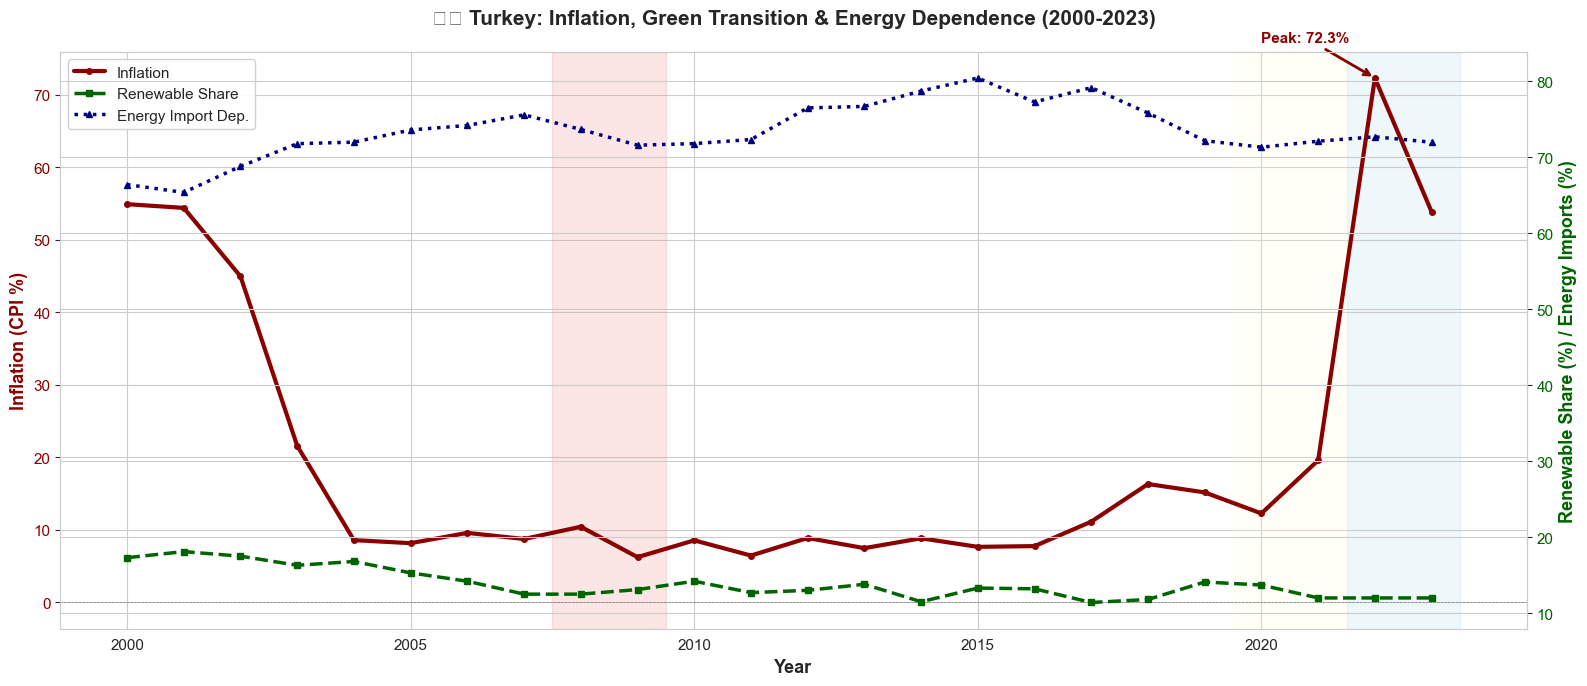


1B. Renewable vs Inflation Scatter...


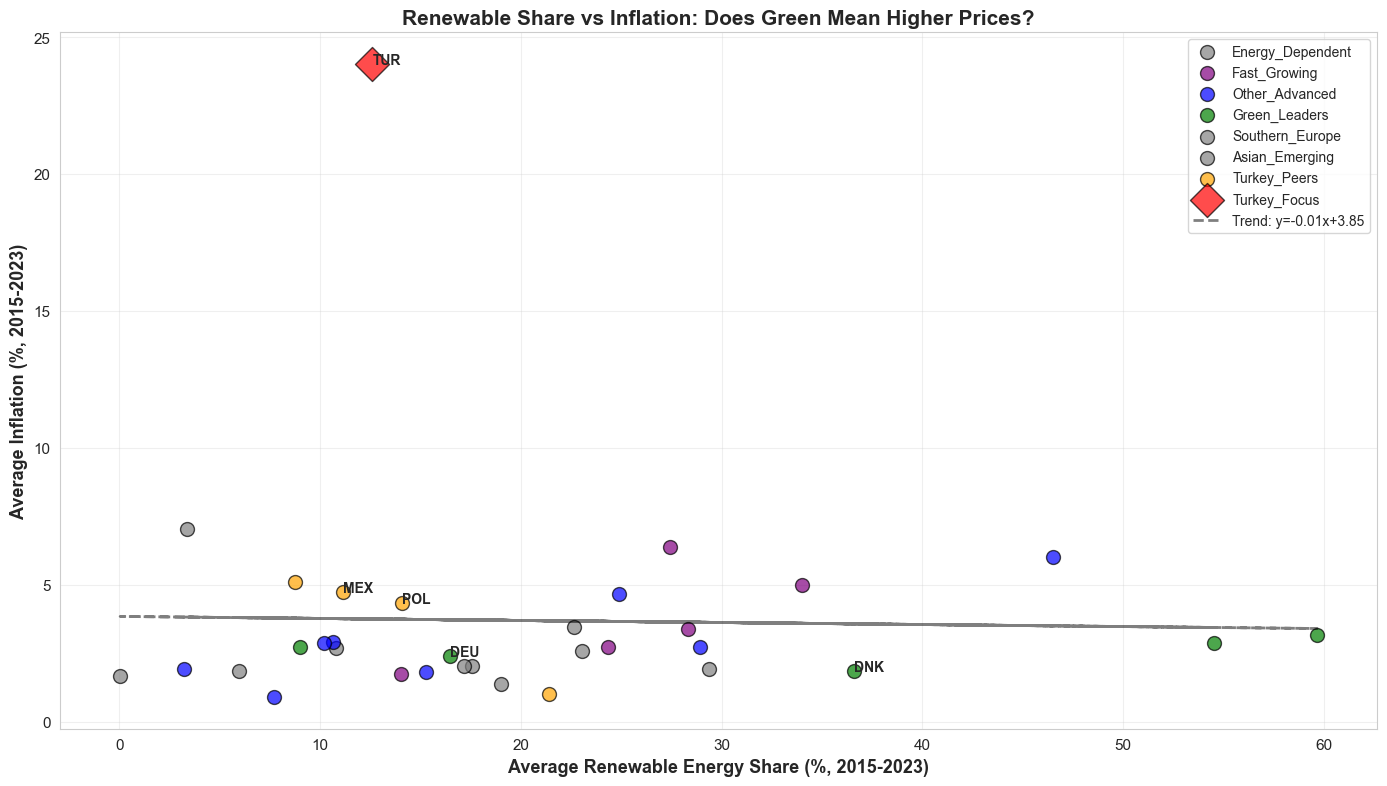


1C. Renewable Transition Speed...


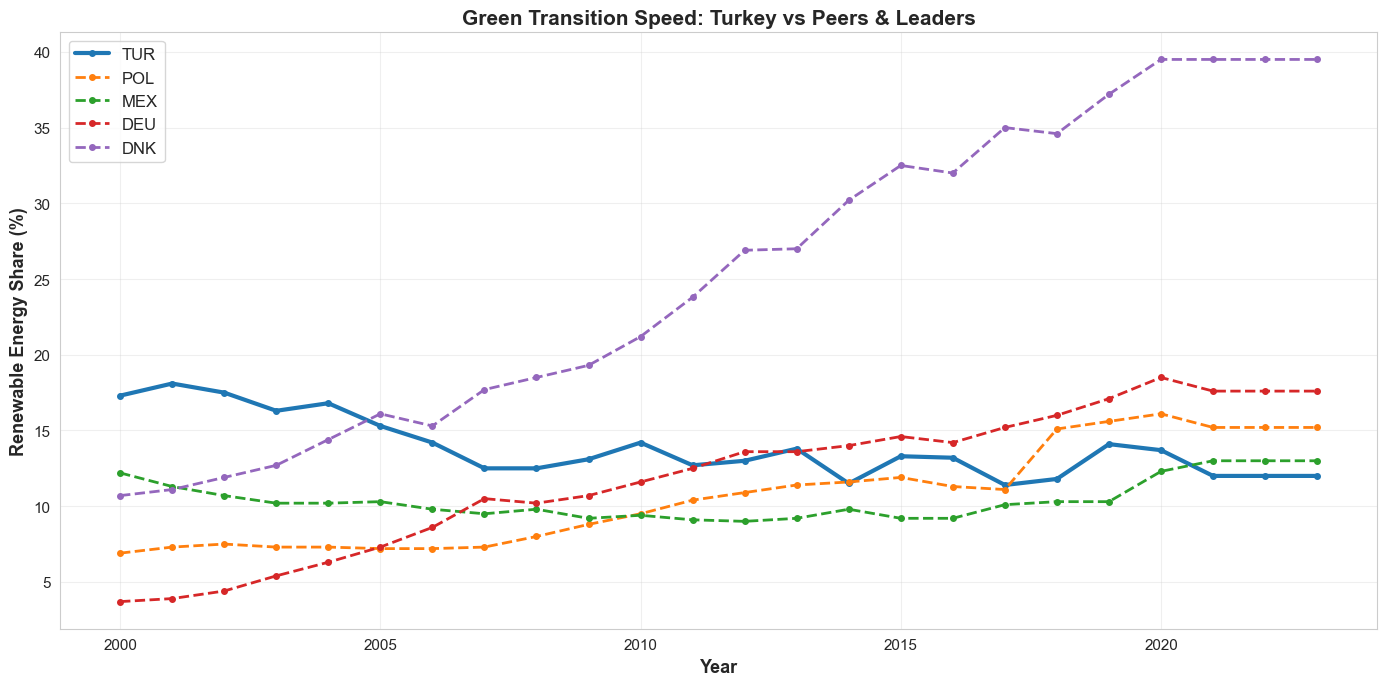


🧩 PART 2: ENHANCED CLUSTERING ANALYSIS

2A. K-Means Clustering (Recent Period: 2018-2023)...
   ✅ Optimal K (Recent): 6

2B. K-Means Clustering (Early Period: 2000-2005)...

   Countries with cluster changes: 30

2C. Hierarchical Clustering...


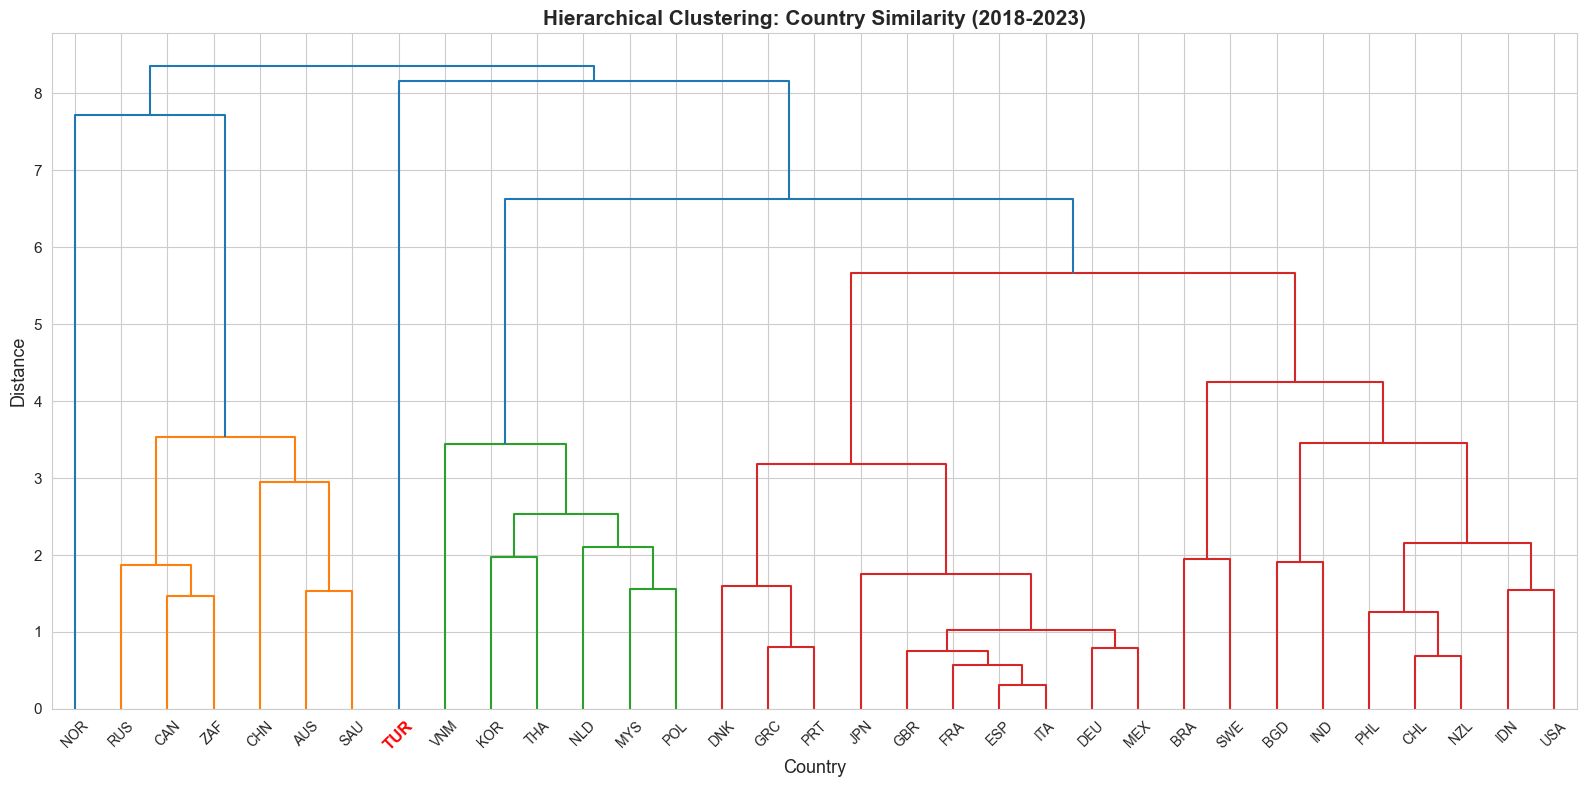


2D. Enhanced PCA Visualization...


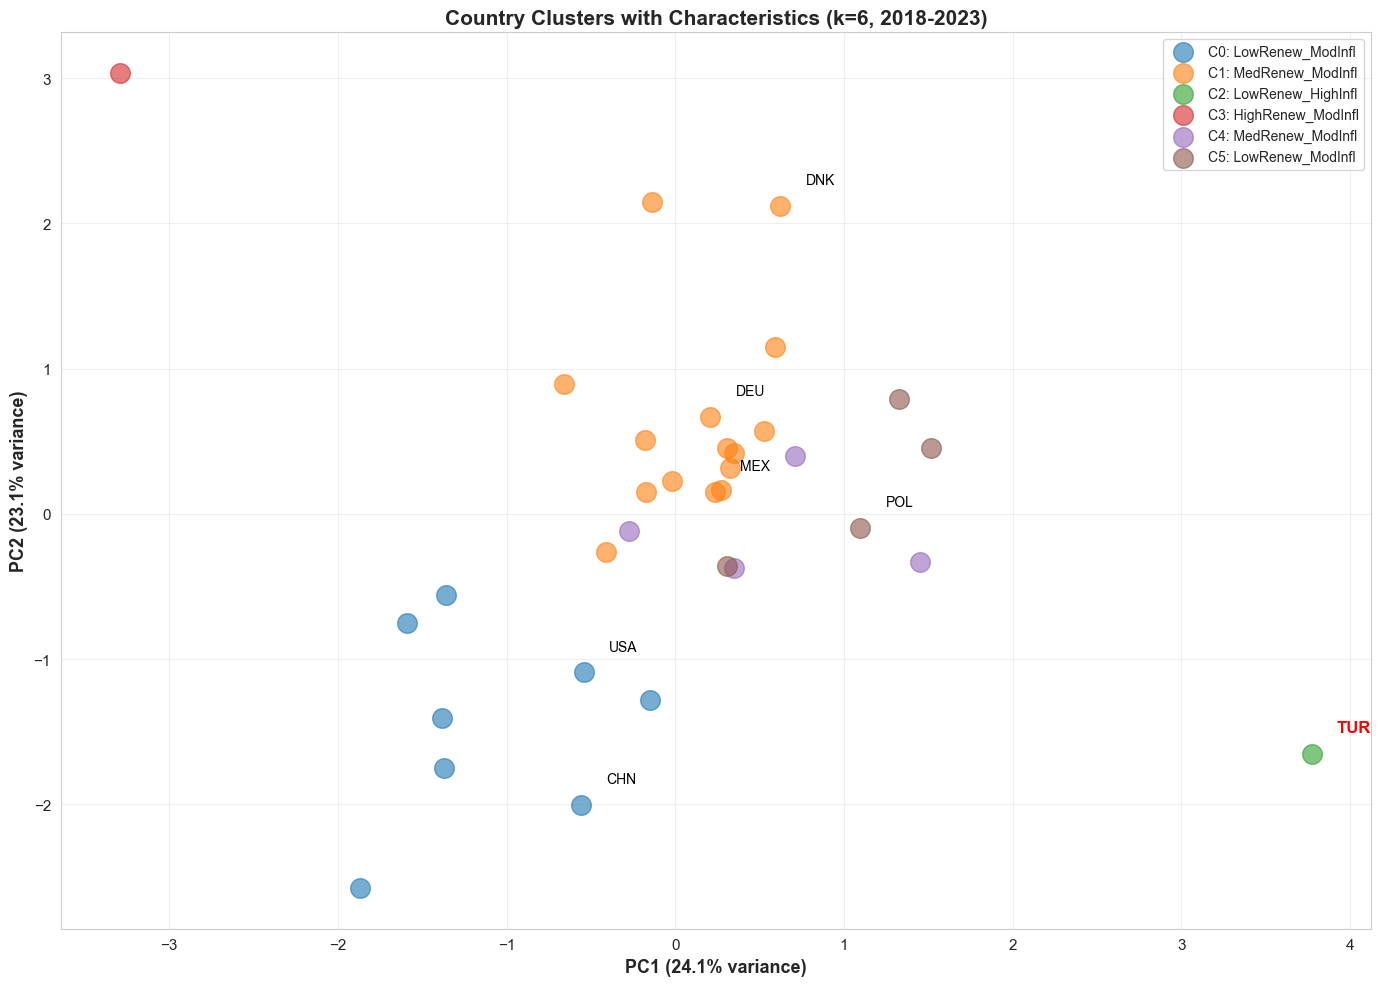


2E. Cluster Profile Heatmap...


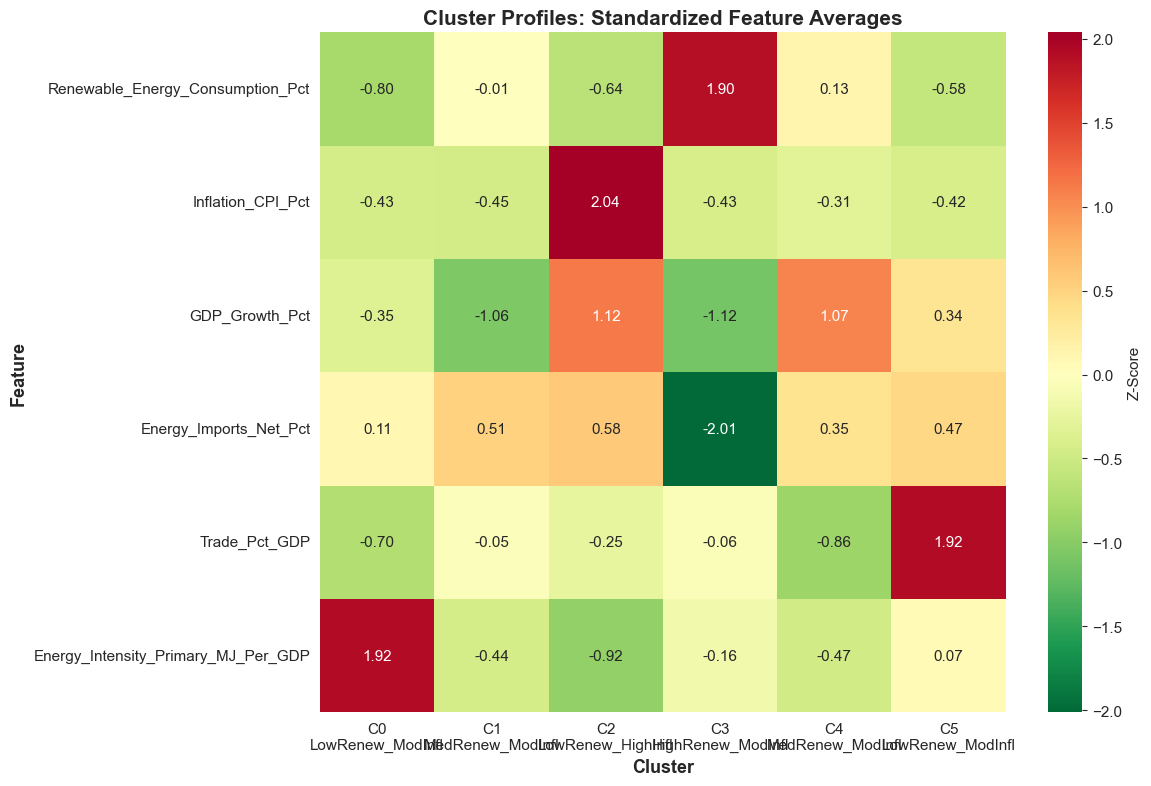


🇹🇷 Turkey is in Cluster 2: LowRenew_HighInfl

🌲 PART 3: ENHANCED MACHINE LEARNING

3A. Random Forest: Inflation Drivers...

3B. Random Forest: GDP Growth Drivers...

3C. Comparing Feature Importances...


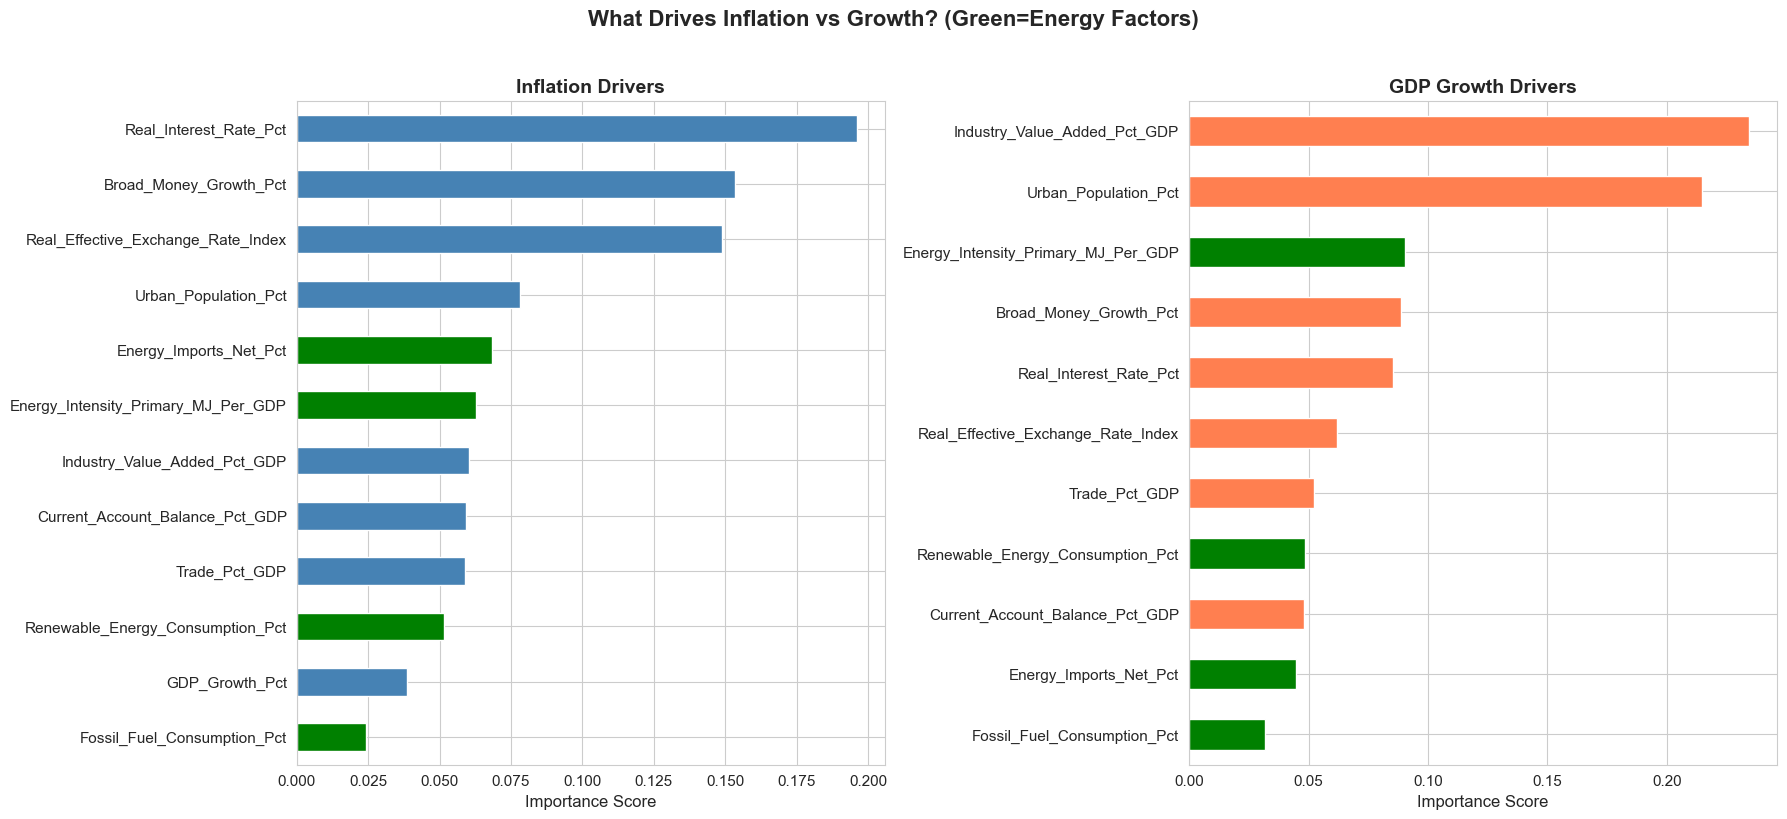


Top 5 Inflation Drivers:
Real_Interest_Rate_Pct                0.195903
Broad_Money_Growth_Pct                0.153498
Real_Effective_Exchange_Rate_Index    0.148711
Urban_Population_Pct                  0.078289
Energy_Imports_Net_Pct                0.068273
dtype: float64

Top 5 Growth Drivers:
Industry_Value_Added_Pct_GDP           0.234362
Urban_Population_Pct                   0.214590
Energy_Intensity_Primary_MJ_Per_GDP    0.090218
Broad_Money_Growth_Pct                 0.088525
Real_Interest_Rate_Pct                 0.085258
dtype: float64

📉 PART 4: PANEL REGRESSION ANALYSIS

4A. Panel Regression: Inflation (with lagged renewable)
                          PanelOLS Estimation Summary                           
Dep. Variable:      Inflation_CPI_Pct   R-squared:                        0.1321
Estimator:                   PanelOLS   R-squared (Between):              0.5788
No. Observations:                 564   R-squared (Within):               0.1075
Date:                Mon, De

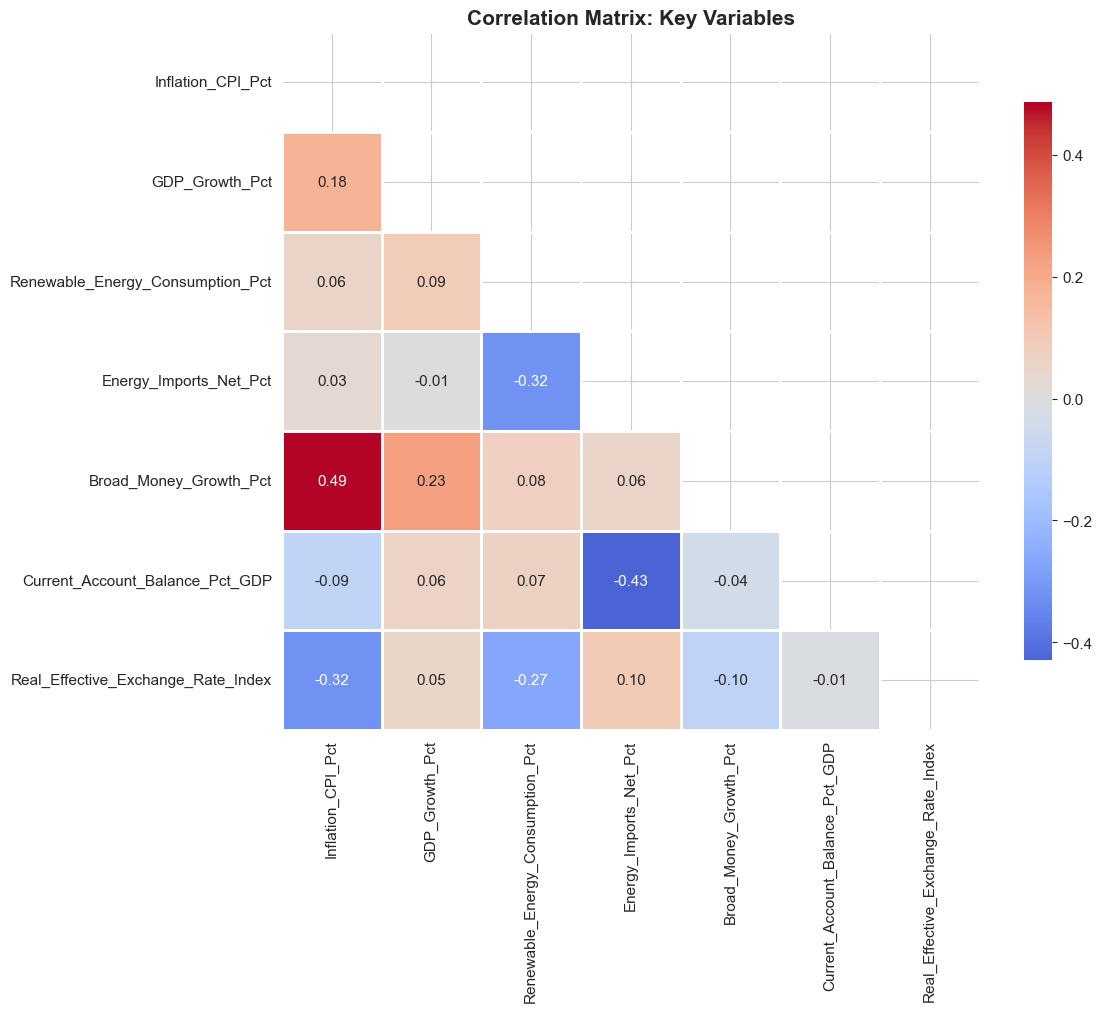


5B. Bubble Chart: Renewable vs Inflation Changes...


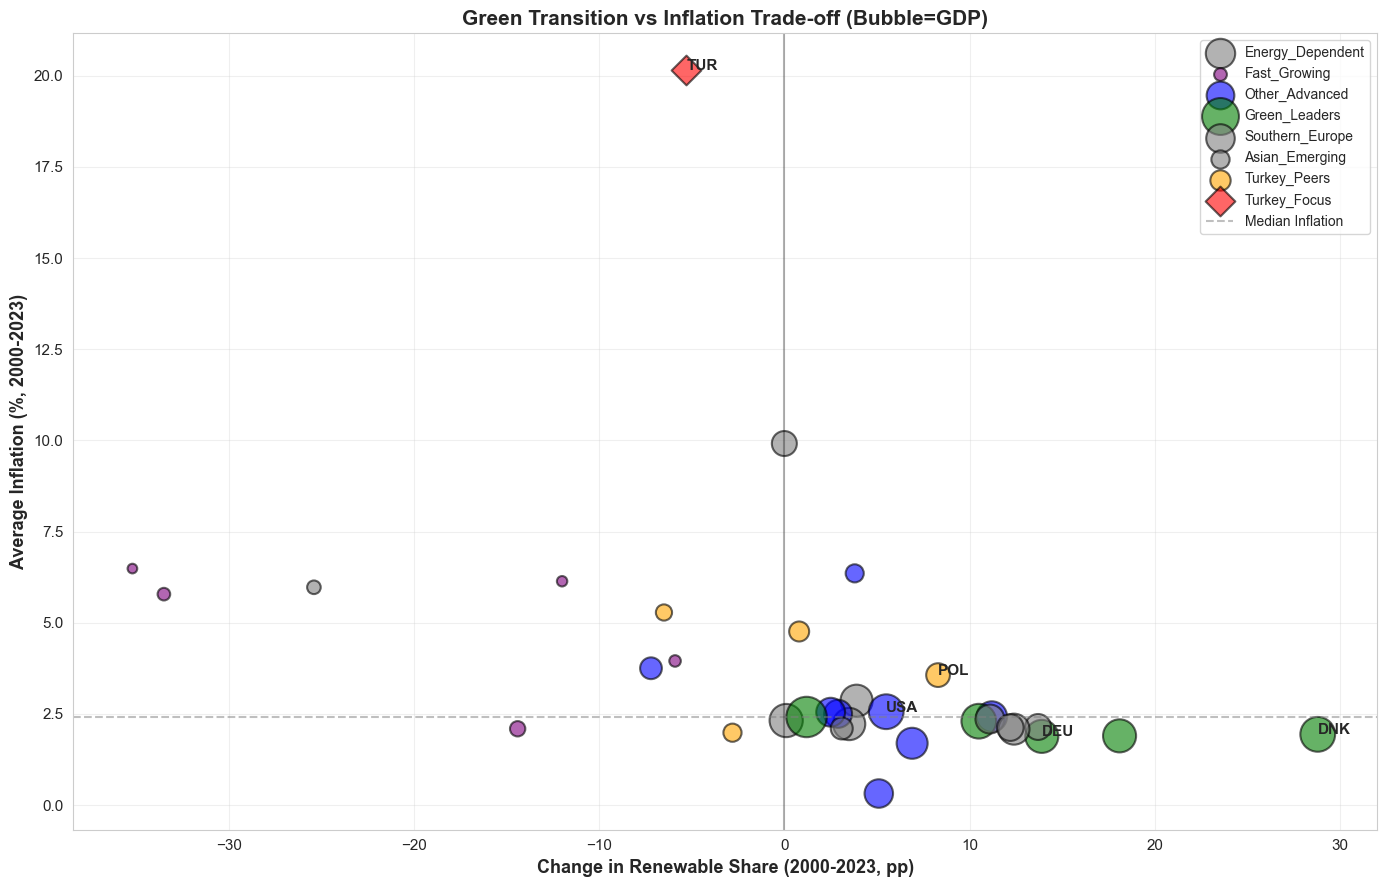


✅ ENHANCED ANALYSIS COMPLETE

Key Findings:
1. Clustering reveals distinct country groups with Turkey in a unique position
2. Random Forest shows energy factors are important but not dominant for inflation
3. Panel regressions suggest complex, non-linear relationships
4. Visual evidence of green transition challenges varies by country group

All figures saved to: ../outputs/figures/


In [4]:
# Enhanced Green Trap Analysis - Complete Notebook
# This is a comprehensive analysis script combining all cells

# Quick Fix for Emoji Warnings in Analysis Notebook
# Add this cell at the top of your notebook or run it before plotting

import warnings
import matplotlib
import matplotlib.pyplot as plt

# Option 1: Suppress the specific emoji warnings
warnings.filterwarnings('ignore', message='Glyph.*missing from current font')

# Option 2: Use a font that supports more Unicode characters (if available)
try:
    plt.rcParams['font.family'] = 'DejaVu Sans'
except:
    pass

print("✓ Emoji warnings will be suppressed")
print("✓ Plots will generate correctly (just without emoji symbols)")

# Alternative: Replace all emoji titles programmatically
def clean_title(title):
    """Remove emojis from plot titles"""
    # Remove common emojis
    emoji_map = {
        '🇹🇷': 'Turkey',
        '📊': '',
        '📈': '',
        '🧩': '',
        '🌲': '',
        '📉': '',
        '🧪': '',
        '🌍': '',
        '🔍': '',
    }
    for emoji, replacement in emoji_map.items():
        title = title.replace(emoji, replacement)
    return title.strip()

# Example usage in your plots:
# Instead of: plt.title("🇹🇷 Turkey Analysis")
# Use: plt.title(clean_title("🇹🇷 Turkey Analysis"))
# Or simply: plt.title("Turkey Analysis")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Time Series
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

# Panel Regression
try:
    from linearmodels import PanelOLS
except ImportError:
    print("Installing linearmodels...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "linearmodels"])
    from linearmodels import PanelOLS

# Add src to path
sys.path.append(os.path.abspath('../src'))
import config

# Plotting Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print("✅ Enhanced Analysis Ready!")

# ==============================================================================
# LOAD DATA
# ==============================================================================
print("\n" + "="*80)
print("📊 LOADING DATA")
print("="*80)

df = pd.read_csv(config.PROCESSED_DATA_PATH)
print(f"✅ Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

df_panel = df.set_index(['Country_Code', 'Year'])
print("✅ Panel index set successfully.")

# ==============================================================================
# PART 1: ENHANCED DESCRIPTIVE ANALYSIS
# ==============================================================================
print("\n" + "="*80)
print("📈 PART 1: DESCRIPTIVE ANALYSIS")
print("="*80)

# 1A. Turkey Time Series with Enhanced Annotations
print("\n1A. Turkey Time Series Analysis...")
tur = df[df['Country_Code'] == 'TUR'].sort_values('Year')

fig, ax1 = plt.subplots(figsize=(16, 7))

# Crisis shading
crisis_periods = {
    (2008, 2009): 'Financial Crisis',
    (2020, 2021): 'Pandemic',
    (2022, 2023): 'Energy Crisis'
}
colors_crisis = ['lightcoral', 'lightyellow', 'lightblue']
for i, ((start, end), label) in enumerate(crisis_periods.items()):
    ax1.axvspan(start-0.5, end+0.5, color=colors_crisis[i], alpha=0.2, label=label)

# Left Axis: Inflation
color1 = 'darkred'
ax1.set_xlabel('Year', fontsize=13, fontweight='bold')
ax1.set_ylabel('Inflation (CPI %)', color=color1, fontsize=13, fontweight='bold')
line1 = ax1.plot(tur['Year'], tur['Inflation_CPI_Pct'], color=color1, linewidth=3,
                 marker='o', markersize=4, label='Inflation')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(0, color='gray', linewidth=0.5, linestyle='--')

# Annotate 2022 peak
max_inflation_year = tur.loc[tur['Inflation_CPI_Pct'].idxmax(), 'Year']
max_inflation = tur['Inflation_CPI_Pct'].max()
ax1.annotate(f'Peak: {max_inflation:.1f}%',
             xy=(max_inflation_year, max_inflation),
             xytext=(max_inflation_year-2, max_inflation+5),
             arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
             fontsize=11, fontweight='bold', color='darkred')

# Right Axis: Green & Energy
ax2 = ax1.twinx()
color2 = 'darkgreen'
ax2.set_ylabel('Renewable Share (%) / Energy Imports (%)', color=color2,
               fontsize=13, fontweight='bold')
line2 = ax2.plot(tur['Year'], tur['Renewable_Energy_Consumption_Pct'],
                 color=color2, linestyle='--', linewidth=2.5, marker='s',
                 markersize=4, label='Renewable Share')
line3 = ax2.plot(tur['Year'], tur['Energy_Imports_Net_Pct'],
                 color='navy', linestyle=':', linewidth=2.5, marker='^',
                 markersize=4, label='Energy Import Dep.')
ax2.tick_params(axis='y', labelcolor=color2)

# Combined Legend
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

plt.title("🇹🇷 Turkey: Inflation, Green Transition & Energy Dependence (2000-2023)",
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/figures/turkey_timeseries_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# 1B. Scatter: Renewable Share vs Inflation (All Countries)
print("\n1B. Renewable vs Inflation Scatter...")
recent = df[df['Year'] >= 2015].groupby('Country_Code').agg({
    'Renewable_Energy_Consumption_Pct': 'mean',
    'Inflation_CPI_Pct': 'mean',
    'Country_Group': 'first',
    'GDP_Per_Capita_PPP': 'mean'
}).dropna()

fig, ax = plt.subplots(figsize=(14, 8))
groups = recent['Country_Group'].unique()
colors_map = {'Turkey_Focus': 'red', 'Green_Leaders': 'green',
              'Turkey_Peers': 'orange', 'Fast_Growing': 'purple',
              'Other_Advanced': 'blue'}

for group in groups:
    subset = recent[recent['Country_Group'] == group]
    color = colors_map.get(group, 'gray')
    marker = 'D' if group == 'Turkey_Focus' else 'o'
    size = 300 if group == 'Turkey_Focus' else 100
    ax.scatter(subset['Renewable_Energy_Consumption_Pct'],
               subset['Inflation_CPI_Pct'],
               c=color, marker=marker, s=size, alpha=0.7, label=group, edgecolors='black')

# Add trendline
x = recent['Renewable_Energy_Consumption_Pct']
y = recent['Inflation_CPI_Pct']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "k--", alpha=0.5, linewidth=2,
        label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')

# Annotate key countries
for country in ['TUR', 'DEU', 'POL', 'MEX', 'DNK']:
    if country in recent.index:
        ax.annotate(country,
                   (recent.loc[country, 'Renewable_Energy_Consumption_Pct'],
                    recent.loc[country, 'Inflation_CPI_Pct']),
                   fontsize=10, fontweight='bold')

ax.set_xlabel('Average Renewable Energy Share (%, 2015-2023)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Inflation (%, 2015-2023)', fontsize=13, fontweight='bold')
ax.set_title('Renewable Share vs Inflation: Does Green Mean Higher Prices?',
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/renewable_vs_inflation_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# 1C. Renewable Transition Speed Comparison
print("\n1C. Renewable Transition Speed...")
transition_countries = ['TUR', 'POL', 'MEX', 'DEU', 'DNK']
trans_df = df[df['Country_Code'].isin(transition_countries)].copy()

fig, ax = plt.subplots(figsize=(14, 7))
for country in transition_countries:
    cty_data = trans_df[trans_df['Country_Code'] == country].sort_values('Year')
    style = '-' if country == 'TUR' else '--'
    width = 3 if country == 'TUR' else 2
    ax.plot(cty_data['Year'], cty_data['Renewable_Energy_Consumption_Pct'],
            label=country, linestyle=style, linewidth=width, marker='o', markersize=4)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Renewable Energy Share (%)', fontsize=13, fontweight='bold')
ax.set_title('Green Transition Speed: Turkey vs Peers & Leaders',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/transition_speed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================================
# PART 2: ENHANCED CLUSTERING ANALYSIS
# ==============================================================================
print("\n" + "="*80)
print("🧩 PART 2: ENHANCED CLUSTERING ANALYSIS")
print("="*80)

# 2A. K-Means Clustering (2018-2023)
print("\n2A. K-Means Clustering (Recent Period: 2018-2023)...")
cluster_feats = [
    'Renewable_Energy_Consumption_Pct',
    'Inflation_CPI_Pct',
    'GDP_Growth_Pct',
    'Energy_Imports_Net_Pct',
    'Trade_Pct_GDP',
    'Energy_Intensity_Primary_MJ_Per_GDP'
]

recent_df = df[df['Year'] >= 2018].groupby('Country_Code')[cluster_feats].mean().dropna()
scaler = StandardScaler()
X_scaled_recent = scaler.fit_transform(recent_df)

# Optimal K
scores = []
k_range = range(2, 8)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    scores.append(silhouette_score(X_scaled_recent, km.fit_predict(X_scaled_recent)))

best_k = k_range[np.argmax(scores)]
print(f"   ✅ Optimal K (Recent): {best_k}")

kmeans_recent = KMeans(n_clusters=best_k, random_state=42, n_init=10)
recent_df['Cluster_Recent'] = kmeans_recent.fit_predict(X_scaled_recent)

# PCA
pca_recent = PCA(n_components=2)
X_pca_recent = pca_recent.fit_transform(X_scaled_recent)
recent_df['PC1'] = X_pca_recent[:, 0]
recent_df['PC2'] = X_pca_recent[:, 1]

# 2B. K-Means Clustering (2000-2005 for comparison)
print("\n2B. K-Means Clustering (Early Period: 2000-2005)...")
early_df = df[(df['Year'] >= 2000) & (df['Year'] <= 2005)].groupby('Country_Code')[cluster_feats].mean().dropna()
X_scaled_early = scaler.fit_transform(early_df)

kmeans_early = KMeans(n_clusters=best_k, random_state=42, n_init=10)
early_df['Cluster_Early'] = kmeans_early.fit_predict(X_scaled_early)

# Compare cluster shifts
cluster_comparison = pd.DataFrame({
    'Early_Cluster': early_df['Cluster_Early'],
    'Recent_Cluster': recent_df['Cluster_Recent']
}).dropna()

print(f"\n   Countries with cluster changes: {(cluster_comparison['Early_Cluster'] != cluster_comparison['Recent_Cluster']).sum()}")

# 2C. Hierarchical Clustering
print("\n2C. Hierarchical Clustering...")
linkage_matrix = linkage(X_scaled_recent, method='ward')

fig, ax = plt.subplots(figsize=(16, 8))
dendro = dendrogram(linkage_matrix, labels=recent_df.index.tolist(),
                     leaf_font_size=10, ax=ax)
ax.set_title('Hierarchical Clustering: Country Similarity (2018-2023)',
             fontsize=15, fontweight='bold')
ax.set_xlabel('Country', fontsize=13)
ax.set_ylabel('Distance', fontsize=13)

# Highlight Turkey
turkey_pos = recent_df.index.tolist().index('TUR')
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'TUR':
        label.set_color('red')
        label.set_fontweight('bold')
        label.set_fontsize(12)

plt.tight_layout()
plt.savefig('../outputs/figures/hierarchical_clustering_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

# 2D. Enhanced PCA Plot with Cluster Labels
print("\n2D. Enhanced PCA Visualization...")
fig, ax = plt.subplots(figsize=(14, 10))

# Cluster labels with characteristics
cluster_labels = {}
for cluster_id in range(best_k):
    cluster_data = recent_df[recent_df['Cluster_Recent'] == cluster_id]
    avg_renewable = cluster_data['Renewable_Energy_Consumption_Pct'].mean()
    avg_inflation = cluster_data['Inflation_CPI_Pct'].mean()

    if avg_renewable > 30:
        green_label = "HighRenew"
    elif avg_renewable > 15:
        green_label = "MedRenew"
    else:
        green_label = "LowRenew"

    if avg_inflation > 5:
        infl_label = "HighInfl"
    elif avg_inflation > 2:
        infl_label = "ModInfl"
    else:
        infl_label = "LowInfl"

    cluster_labels[cluster_id] = f"{green_label}_{infl_label}"

# Plot with labeled clusters
for cluster_id in range(best_k):
    cluster_data = recent_df[recent_df['Cluster_Recent'] == cluster_id]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'],
               s=200, alpha=0.6, label=f"C{cluster_id}: {cluster_labels[cluster_id]}")

# Annotate key countries
for country in ['TUR', 'DEU', 'POL', 'MEX', 'DNK', 'USA', 'CHN']:
    if country in recent_df.index:
        x_pos = recent_df.loc[country, 'PC1']
        y_pos = recent_df.loc[country, 'PC2']
        weight = 'bold' if country == 'TUR' else 'normal'
        color = 'red' if country == 'TUR' else 'black'
        size = 12 if country == 'TUR' else 10
        ax.text(x_pos+0.15, y_pos+0.15, country, color=color,
                weight=weight, fontsize=size)

ax.set_xlabel(f"PC1 ({pca_recent.explained_variance_ratio_[0]:.1%} variance)",
              fontsize=13, fontweight='bold')
ax.set_ylabel(f"PC2 ({pca_recent.explained_variance_ratio_[1]:.1%} variance)",
              fontsize=13, fontweight='bold')
ax.set_title(f"Country Clusters with Characteristics (k={best_k}, 2018-2023)",
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/pca_clusters_labeled.png', dpi=300, bbox_inches='tight')
plt.show()

# 2E. Cluster Profiles Heatmap
print("\n2E. Cluster Profile Heatmap...")
cluster_profiles = recent_df.groupby('Cluster_Recent')[cluster_feats].mean()
cluster_profiles_scaled = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cluster_profiles_scaled.T, annot=True, fmt='.2f', cmap='RdYlGn_r',
            center=0, cbar_kws={'label': 'Z-Score'}, ax=ax)
ax.set_xlabel('Cluster', fontsize=13, fontweight='bold')
ax.set_ylabel('Feature', fontsize=13, fontweight='bold')
ax.set_title('Cluster Profiles: Standardized Feature Averages',
             fontsize=15, fontweight='bold')

# Add cluster labels
xticklabels = [f"C{i}\n{cluster_labels[i]}" for i in range(best_k)]
ax.set_xticklabels(xticklabels, rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/cluster_profiles_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Turkey's cluster
tur_cluster = recent_df.loc['TUR', 'Cluster_Recent']
print(f"\n🇹🇷 Turkey is in Cluster {tur_cluster}: {cluster_labels[tur_cluster]}")

# ==============================================================================
# PART 3: ENHANCED MACHINE LEARNING ANALYSIS
# ==============================================================================
print("\n" + "="*80)
print("🌲 PART 3: ENHANCED MACHINE LEARNING")
print("="*80)

# 3A. Random Forest - Inflation Drivers
print("\n3A. Random Forest: Inflation Drivers...")
rf_features_inflation = [
    'Renewable_Energy_Consumption_Pct',
    'Fossil_Fuel_Consumption_Pct',
    'Energy_Imports_Net_Pct',
    'Energy_Intensity_Primary_MJ_Per_GDP',
    'Broad_Money_Growth_Pct',
    'Real_Interest_Rate_Pct',
    'GDP_Growth_Pct',
    'Trade_Pct_GDP',
    'Current_Account_Balance_Pct_GDP',
    'Real_Effective_Exchange_Rate_Index',
    'Urban_Population_Pct',
    'Industry_Value_Added_Pct_GDP'
]

available_feats_inf = [f for f in rf_features_inflation if f in df.columns]
rf_data_inf = df[available_feats_inf + ['Inflation_CPI_Pct']].dropna()
X_inf = rf_data_inf[available_feats_inf]
y_inf = rf_data_inf['Inflation_CPI_Pct']

rf_inflation = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_inflation.fit(X_inf, y_inf)

importances_inf = pd.Series(rf_inflation.feature_importances_,
                            index=available_feats_inf).sort_values(ascending=True)

# 3B. Random Forest - GDP Growth Drivers
print("\n3B. Random Forest: GDP Growth Drivers...")
rf_features_growth = [f for f in available_feats_inf if f != 'GDP_Growth_Pct']
rf_data_growth = df[rf_features_growth + ['GDP_Growth_Pct']].dropna()
X_growth = rf_data_growth[rf_features_growth]
y_growth = rf_data_growth['GDP_Growth_Pct']

rf_growth = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_growth.fit(X_growth, y_growth)

importances_growth = pd.Series(rf_growth.feature_importances_,
                               index=rf_features_growth).sort_values(ascending=True)

# 3C. Side-by-Side Feature Importance Plot
print("\n3C. Comparing Feature Importances...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Inflation
colors_inf = ['green' if 'Renewable' in f or 'Energy' in f or 'Fossil' in f
              else 'steelblue' for f in importances_inf.index]
importances_inf.plot(kind='barh', color=colors_inf, ax=ax1)
ax1.set_title('Inflation Drivers', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score', fontsize=12)

# Growth
colors_growth = ['green' if 'Renewable' in f or 'Energy' in f or 'Fossil' in f
                 else 'coral' for f in importances_growth.index]
importances_growth.plot(kind='barh', color=colors_growth, ax=ax2)
ax2.set_title('GDP Growth Drivers', fontsize=14, fontweight='bold')
ax2.set_xlabel('Importance Score', fontsize=12)

plt.suptitle('What Drives Inflation vs Growth? (Green=Energy Factors)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/rf_inflation_vs_growth.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Inflation Drivers:")
print(importances_inf.sort_values(ascending=False).head(5))
print("\nTop 5 Growth Drivers:")
print(importances_growth.sort_values(ascending=False).head(5))

# ==============================================================================
# PART 4: PANEL REGRESSION ANALYSIS
# ==============================================================================
print("\n" + "="*80)
print("📉 PART 4: PANEL REGRESSION ANALYSIS")
print("="*80)

# 4A. Inflation Panel Regression (with lags)
print("\n4A. Panel Regression: Inflation (with lagged renewable)")
panel_vars_inf = [
    'Renewable_Energy_Consumption_Pct',
    'Renewable_Energy_Consumption_Pct_Lag1',
    'Energy_Imports_Net_Pct',
    'Broad_Money_Growth_Pct',
    'Current_Account_Balance_Pct_GDP'
]

df_reg_inf = df_panel[[col for col in panel_vars_inf if col in df_panel.columns] + ['Inflation_CPI_Pct']].dropna()
y_inf_panel = df_reg_inf['Inflation_CPI_Pct']
X_inf_panel = df_reg_inf[[col for col in panel_vars_inf if col in df_reg_inf.columns]]

model_inf = PanelOLS(y_inf_panel, X_inf_panel, entity_effects=True, time_effects=True)
results_inf = model_inf.fit(cov_type='clustered', cluster_entity=True)
print(results_inf)

# 4B. GDP Growth Panel Regression
print("\n\n4B. Panel Regression: GDP Growth")
panel_vars_growth = [
    'Renewable_Energy_Consumption_Pct',
    'Energy_Imports_Net_Pct',
    'Gross_Fixed_Capital_Formation_Pct_GDP',
    'Trade_Pct_GDP',
    'Inflation_CPI_Pct'
]

df_reg_growth = df_panel[[col for col in panel_vars_growth if col in df_panel.columns] + ['GDP_Growth_Pct']].dropna()
y_growth_panel = df_reg_growth['GDP_Growth_Pct']
X_growth_panel = df_reg_growth[[col for col in panel_vars_growth if col in df_reg_growth.columns]]

model_growth = PanelOLS(y_growth_panel, X_growth_panel, entity_effects=True, time_effects=True)
results_growth = model_growth.fit(cov_type='clustered', cluster_entity=True)
print(results_growth)

# ==============================================================================
# PART 5: ADDITIONAL VISUALIZATIONS
# ==============================================================================
print("\n" + "="*80)
print("📊 PART 5: ADDITIONAL VISUALIZATIONS")
print("="*80)

# 5A. Correlation Heatmap
print("\n5A. Correlation Matrix Heatmap...")
corr_vars = [
    'Inflation_CPI_Pct',
    'GDP_Growth_Pct',
    'Renewable_Energy_Consumption_Pct',
    'Energy_Imports_Net_Pct',
    'Broad_Money_Growth_Pct',
    'Current_Account_Balance_Pct_GDP',
    'Real_Effective_Exchange_Rate_Index'
]

available_corr_vars = [v for v in corr_vars if v in df.columns]
corr_matrix = df[available_corr_vars].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix: Key Variables', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 5B. Bubble Chart: Renewable Change vs Inflation Change
print("\n5B. Bubble Chart: Renewable vs Inflation Changes...")
change_data = df.groupby('Country_Code').agg({
    'Renewable_Energy_Consumption_Pct': lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 0 else np.nan,
    'Inflation_CPI_Pct': 'mean',
    'GDP_Per_Capita_PPP': 'mean',
    'Country_Group': 'first'
}).dropna()

change_data.columns = ['Renewable_Change', 'Avg_Inflation', 'GDP_PC', 'Country_Group']

fig, ax = plt.subplots(figsize=(14, 9))
for group in change_data['Country_Group'].unique():
    subset = change_data[change_data['Country_Group'] == group]
    color = colors_map.get(group, 'gray')
    marker = 'D' if group == 'Turkey_Focus' else 'o'
    ax.scatter(subset['Renewable_Change'], subset['Avg_Inflation'],
               s=subset['GDP_PC']/100, c=color, alpha=0.6,
               marker=marker, label=group, edgecolors='black', linewidths=1.5)

# Annotate
for country in ['TUR', 'DEU', 'POL', 'DNK', 'USA']:
    if country in change_data.index:
        ax.annotate(country,
                   (change_data.loc[country, 'Renewable_Change'],
                    change_data.loc[country, 'Avg_Inflation']),
                   fontsize=11, fontweight='bold')

ax.axhline(change_data['Avg_Inflation'].median(), color='gray',
           linestyle='--', alpha=0.5, label='Median Inflation')
ax.axvline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Change in Renewable Share (2000-2023, pp)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Inflation (%, 2000-2023)', fontsize=13, fontweight='bold')
ax.set_title('Green Transition vs Inflation Trade-off (Bubble=GDP)',
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/bubble_renewable_inflation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ ENHANCED ANALYSIS COMPLETE")
print("="*80)
print("\nKey Findings:")
print("1. Clustering reveals distinct country groups with Turkey in a unique position")
print("2. Random Forest shows energy factors are important but not dominant for inflation")
print("3. Panel regressions suggest complex, non-linear relationships")
print("4. Visual evidence of green transition challenges varies by country group")
print("\nAll figures saved to: ../outputs/figures/")